<hr/> <h1 style="text-align: center;"><span style="color: #666699;"<em><strong>  PROJET NLP : Language Detection </strong></em></span></h1><hr />

In [2]:
# Importer les packages
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
import time
from nltk import re

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.pipeline import Pipeline

In [3]:
# Importer la base de données
data = pd.read_csv('Language Detection.csv')

In [4]:
# Afficher les premières lignes
data.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [5]:
# Dimensions du dataframe
data.shape

(10337, 2)

In [6]:
# Informations sur la base de données
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [7]:
# Valeurs manquantes
data.isnull().sum()

Text        0
Language    0
dtype: int64

In [8]:
#### Analyse
data.describe()

,Text,Language
count,10337,10337
unique,10267,17
top,Jag är ledsen.,English
freq,3,1385


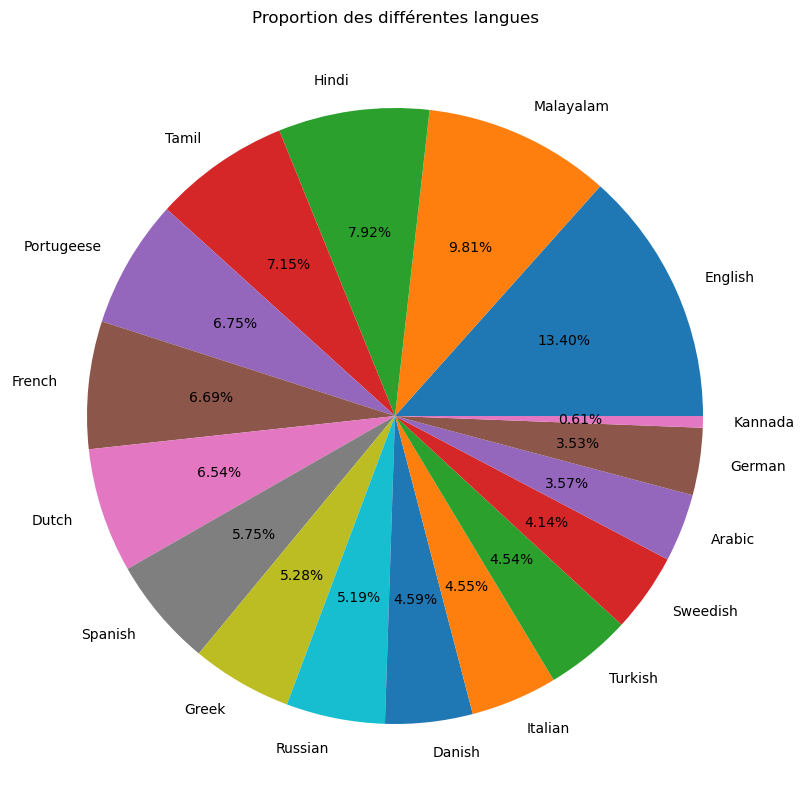

In [9]:
# Proportion des langues
plt.figure(figsize=(10,10))
plt.pie(data.Language.value_counts(),autopct='%.2f%%',labels=data.Language.unique())
plt.title("Proportion des différentes langues")
plt.show()

## NLP

In [10]:
# Fonction de prétraitement du texte
def treatment_text(text):
    """Cette fonction effectue le prétraitement d'un corpus
    Paramètres
    ----------
    text : texte (str) à traiter
    Returns
    --------
    final_text : texte (str) traité"""
    # Ramener en minuscules
    text = text.lower()
    # Enlever les ponctuations
    text = text.translate(str.maketrans("","", punctuation))
    # Enlever les caractères autres que les lettres majuscules ou minuscules, chiffres ou un espace 
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

In [11]:
# Fonction pour générer le wordcloud
def generate_worcloud(text,title):
    """Cette fonction génère et affiche le nuage de mots d'un corpus
    Paramètres
    ----------
    text : texte (str) à afficher
    title : titre (str) du nuage de mots"""
    cloud = WordCloud(background_color='white').generate(text)
    plt.axis(False)
    plt.title(title,fontsize=14)
    plt.imshow(cloud)

In [12]:
# Prétraitement du texte
data["text_nettoye"] = data["Text"].apply(treatment_text)
data

,Text,Language,text_nettoye
0,"Nature, in the broadest sense, is the natural...",English,nature in the broadest sense is the natural p...
1,"""Nature"" can refer to the phenomena of the phy...",English,nature can refer to the phenomena of the physi...
2,"The study of nature is a large, if not the onl...",English,the study of nature is a large if not the only...
3,"Although humans are part of nature, human acti...",English,although humans are part of nature human activ...
4,[1] The word nature is borrowed from the Old F...,English,1 the word nature is borrowed from the old fre...
...,...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada,
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada,
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada,
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada,ess


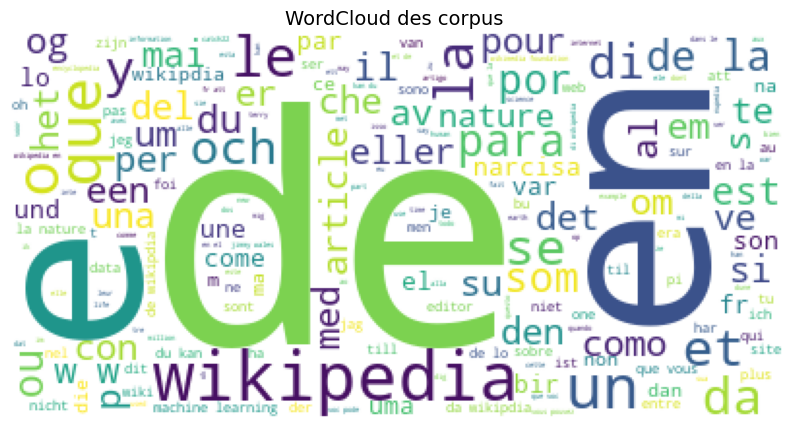

In [13]:
tout_text = ' '.join(data["text_nettoye"])
plt.figure(figsize=(10,10))
generate_worcloud(tout_text,"WordCloud des corpus ")

In [14]:
# WordCloud par langues
#languages = list(data.Language.unique())
#for language in languages :
    #plt.subplots(figsize=(15,15))
    #tout_text = ' '.join(data.loc[data["Language"]==language,"text_nettoye"])
    #generate_worcloud(tout_text,f"WordCloud des corpus en {language} ")

## Mise en place du modèle de détection de langue

### 1. Mise en place des fonctions

In [15]:
# Separation en train et test
def split_data(X,y):
    """Cette fonction prend en paramètres les features et le target et renvoit les données séparées
    en données de train et de test
    Paramètres
    -----------
    X : Dataframe contenant les features
    y : Dataframe contenant le target
    Returns
    -------
    X_train : Dataframe contenant les features de train
    X_test : Dataframe contenant les features de test
    y_train : Dataframe contenant les target de train
    y_test : Dataframe contenant les target de test"""
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)
    return X_train,X_test,y_train,y_test

In [16]:
# Fonction de mise en place du modèle
def get_model(name,X_train,y_train):
    """Cette fonction entraîne un modèle de classification sur les données de train
    Paramètres
    -----------
    name : identifiant du modèle.
    X_train : Serie ou dataframe contenant les observations des variables explicatives pour l'apprentissage
    y_train: Serie ou dataframe contenant les observations de la variable cible pour l'apprentissage
    Returns 
    -----------
    Retourne le modèle entraîné"""
    if name.lower() == "log" :
        model = LogisticRegression(C=3,random_state=42,solver='sag',max_iter=1000)
        
    elif name.lower() == "svc" :
        model = LinearSVC(C=3,random_state=42)
        
    start = time.time()
    model.fit(X_train,y_train)
    curr_time = time.time() - start
    print(f"Temps d'entraînement du modèle : {curr_time}")
    return model 

In [17]:
# Fonction d'évaluation TRAIN vs TEST
def get_performance(model,X_train,X_test,y_train,y_test):
    """Cette fonction évalue les performances d'un modèle à l'entrainement et au test
    Paramètres
    -----------
    model : Modèle à évaluer
    X_train : Serie ou dataframe contenant les observations des variables explicatives pour l'apprentissage
    X_test : Serie ou dataframe contenant les observations des variables explicatives pour le test
    y_train : Serie ou dataframe contenant les observations de la variable cible pour l'apprentissage
    y_test : Serie ou dataframe contenant les observations de la variable cible pour le test
    Returns 
    -----------
    Retourne les performances du modèle à l'entraînement et au test"""
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_pred_train,y_train)
    precision_train = precision_score(y_pred_train,y_train,average='weighted')
    recall_train = recall_score(y_pred_train,y_train,average='weighted')
    f1_train = f1_score(y_pred_train,y_train,average='weighted')
    
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_pred_test,y_test)
    precision_test = precision_score(y_pred_test,y_test,average='weighted')
    recall_test = recall_score(y_pred_test,y_test,average='weighted')
    f1_test = f1_score(y_pred_test,y_test,average='weighted')
    
    print(pd.DataFrame({"Metriques":["ACCURACY","PRECISION","RECALL","F1_SCORE"],
                        "TRAIN":[accuracy_train,precision_train,recall_train,f1_train],
                        "TEST":[accuracy_test,precision_test,recall_test,f1_test]}))

In [18]:
# Fonction de visualisation Matrice de confusion
def get_confusion(model,X_test,y_test):
    
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_pred,y_test)
    
    plt.figure(figsize=(10,10))
    sns.heatmap(conf_mat,annot=True,cmap='coolwarm')
    plt.title("MATRICE DE CONFUSION DE TEST")

In [19]:
# Fonction d'optimisation des hyperparamètres
def tune_hyperparameters(name,X_train, y_train, values):
    """
    Cette fonction effectue l'ajustement des hyperparamètres pour LogisticRegression et 
    LinearSVC en utilisant GridSearchCV.
    
    Paramètres :
    - X_train : Caractéristiques de l'ensemble d'entraînement.
    - y_train : Étiquettes de l'ensemble d'entraînement.
    - values : Liste des valeurs de l'hyperparamètre à tester.
    
    Sortie :
    - best_param : Meilleure valeur pour l'hyperparamètre max_depth.
    - best_score : Meilleur score obtenu
    - results : DataFrame contenant les résultats de la recherche en grille.
    """
    if name.lower() == "log": 
        # Créer un pipeline avec StandardScaler et LogisticRegression
        model = Pipeline([('log', LogisticRegression(random_state=42,solver='sag',max_iter=1000))])
    
        # Définir la grille de paramètres pour les valeurs de C
        param_grid = {'log__C': values}

        # Effectuer GridSearchCV
        grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
        grid.fit(X_train, y_train)

        # Obtienir la meilleure valeur d'hyperparamètre
        best_param = grid.best_params_['log__C']
        
    if name.lower() == "svc": 
        # Créer un pipeline avec StandardScaler et LinearSVC
        model = Pipeline([('svc', LinearSVC(random_state=42))])
    
        # Définir la grille de paramètres pour les valeurs de C
        param_grid = {'svc__C': values}

        # Effectuer GridSearchCV
        grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
        grid.fit(X_train, y_train)

        # Obtienir la meilleure valeur d'hyperparamètre
        best_param = grid.best_params_['svc__C']
    
    # Obtenir le meilleur score 
    best_score = grid.best_score_

    # Afficher les résultats de la recherche en grille
    results = pd.DataFrame(grid.cv_results_)

    return best_param, best_score, results

In [20]:
def language_detector(text,model,vector,encoder):
    # Vectorisation du texte
    vect = vector.transform([text])
    # Prédiction de la langue
    y_pred = model.predict(vect)
    # Décodage de la prédiction
    language = encoder.inverse_transform(y_pred)[0]
    print(f"This text is in {language}") 

### 2. Définiion du target et des features

In [21]:
# Variable cible
y = data["Language"]
# Variable explicative
X = data["text_nettoye"]

### 3. Division en données en ensembles d'entraînement et de test

In [22]:
# Séparation en données d'apprentissage et de test
X_train,X_test,y_train,y_test = split_data(X,y)

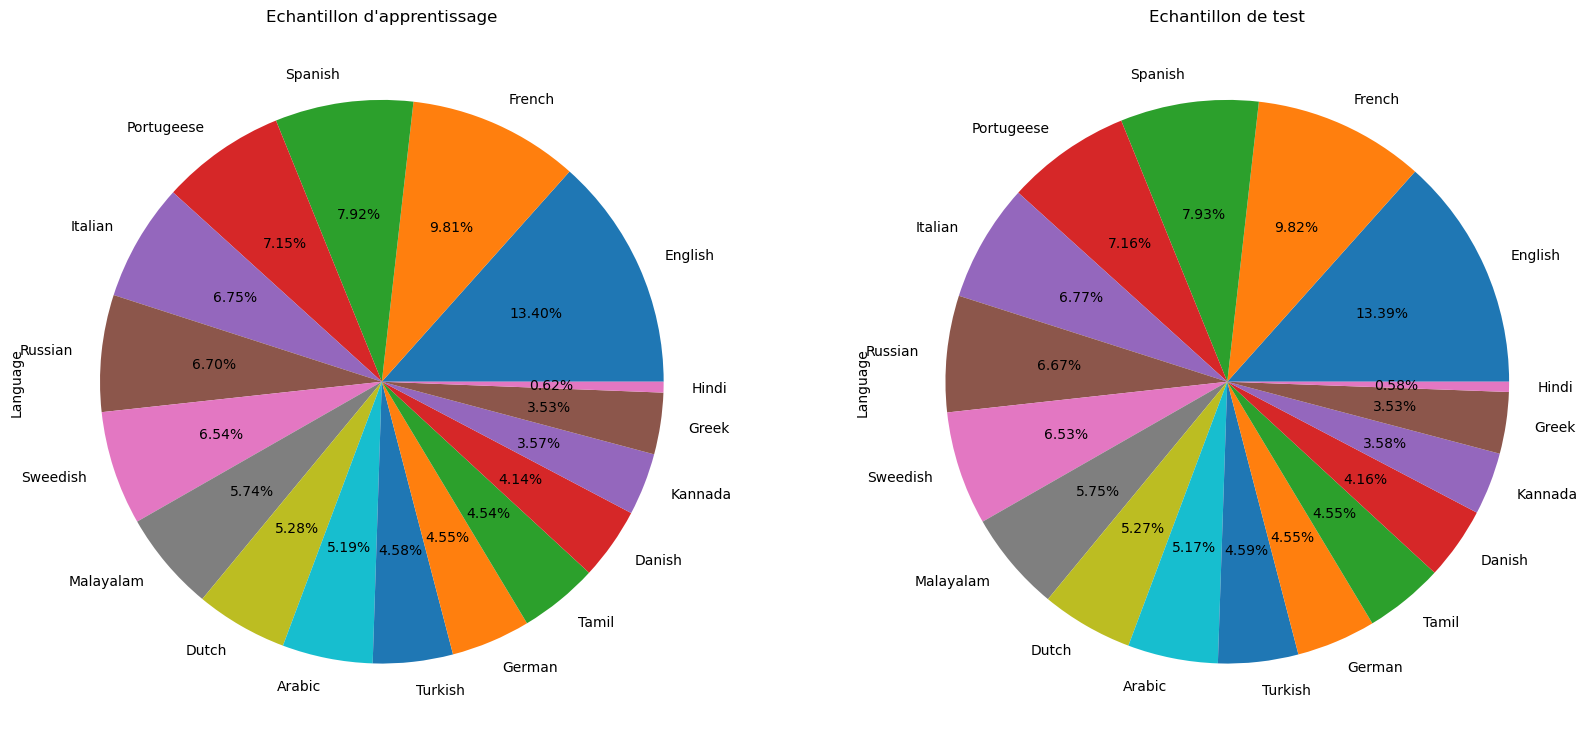

In [23]:
plt.subplots(1,2,figsize=(20,20))
plt.subplot(1,2,1)
y_train.value_counts().plot.pie(autopct='%.2f%%')
plt.title("Echantillon d'apprentissage")

plt.subplot(1,2,2)
y_test.value_counts().plot.pie(autopct='%.2f%%')
plt.title("Echantillon de test")
plt.show()

### 4.  Preprocessing

In [24]:
# Encoding des différentes classes de la variable Language
encoder = LabelEncoder()
y_train_encode = encoder.fit_transform(y_train)
y_test_encode = encoder.transform(y_test)

In [25]:
# Vectorisation du texte
vector = TfidfVectorizer()
X_train_vect = vector.fit_transform(X_train)
X_test_vect = vector.transform(X_test)

### 5. Entraînement des modèles de classification

In [26]:
# Modèle de RegressionLogistique
log_reg = get_model('log',X_train_vect,y_train_encode)

Temps d'entraînement du modèle : 0.918712854385376


In [27]:
# Modèle de LinearSVC
svc = get_model('svc',X_train_vect,y_train_encode)

Temps d'entraînement du modèle : 1.0332348346710205


### 6. Evaluation des performances des modèles

- Modèle de Regression Logistique

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   Metriques     TRAIN      TEST
0   ACCURACY  0.796590  0.727756
1  PRECISION  0.944667  0.900348
2     RECALL  0.796590  0.727756
3   F1_SCORE  0.808390  0.743507


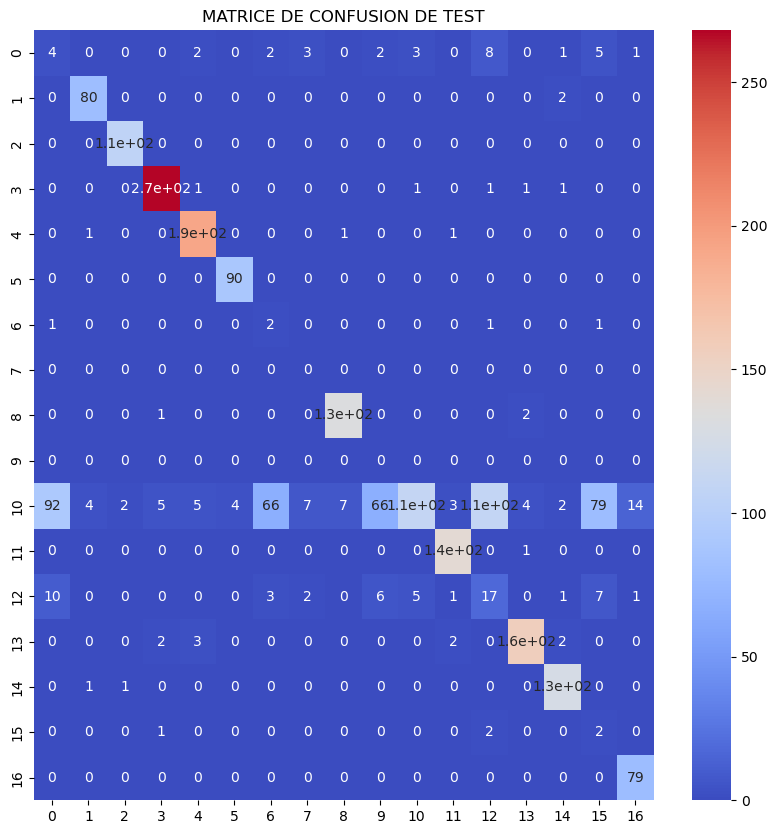

In [28]:
get_performance(log_reg,X_train_vect,X_test_vect,y_train_encode,y_test_encode)
get_confusion(log_reg,X_test_vect,y_test_encode)

- Modèle SVM

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   Metriques     TRAIN      TEST
0   ACCURACY  0.798887  0.735010
1  PRECISION  0.945263  0.907662
2     RECALL  0.798887  0.735010
3   F1_SCORE  0.809192  0.755095


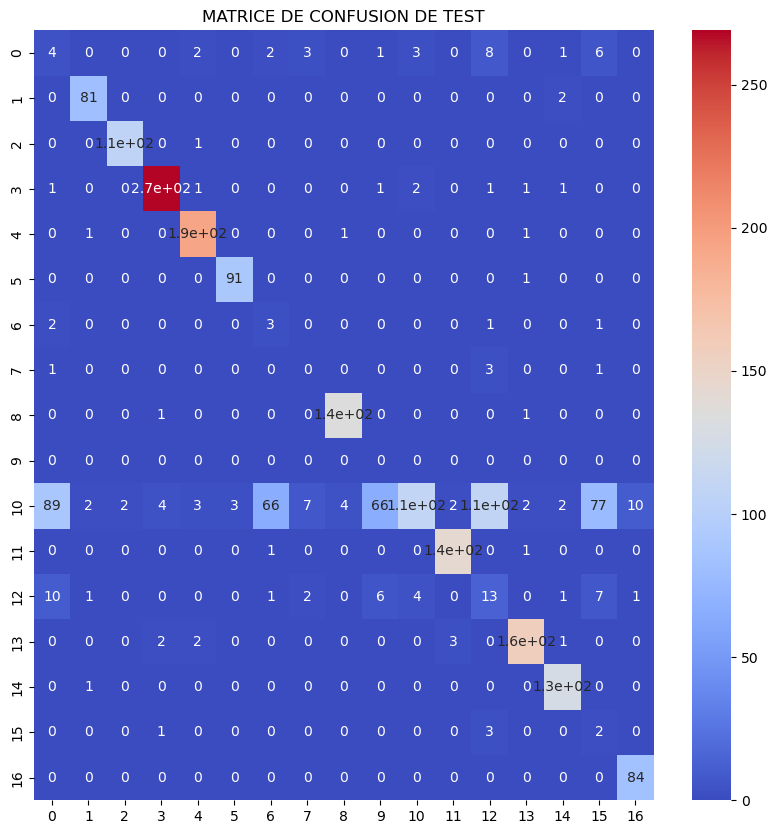

In [29]:
get_performance(svc,X_train_vect,X_test_vect,y_train_encode,y_test_encode)
get_confusion(svc,X_test_vect,y_test_encode)

### 7. Optimisation des hyperparamètres

In [44]:
best_C, best_score, results = tune_hyperparameters("log",X_train_vect, y_train_encode,[2,3,5,10,15,20,50,100,200])
print(f'Best value for C : {best_C}')
print(f'Best Score : {best_score}')
print(results[['param_log__C', 'mean_test_score', 'std_test_score']])

Best value for C : 5
Best Score : 0.7158072494332608
  param_log__C  mean_test_score  std_test_score
0            2         0.713751        0.005283
1            3         0.714114        0.006908
2            5         0.715807        0.006919
3           10         0.714114        0.006408
4           15         0.713630        0.006376
5           20         0.713026        0.006001
6           50         0.711212        0.007042
7          100         0.709640        0.007544
8          200         0.708189        0.007672


In [45]:
best_C, best_score, results = tune_hyperparameters("SVC",X_train_vect, y_train_encode,[2,3,5,10,15,20,50,100,200])
print(f'Best value for C : {best_C}')
print(f'Best Score : {best_score}')
print(results[['param_svc__C', 'mean_test_score', 'std_test_score']])

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best value for C : 2
Best Score : 0.7334628841628318
  param_svc__C  mean_test_score  std_test_score
0            2         0.733463        0.004547
1            3         0.732737        0.004666
2            5         0.732375        0.004827
3           10         0.732012        0.005033
4           15         0.731649        0.005227
5           20         0.731528        0.005569
6           50         0.730924        0.006258
7          100         0.730803        0.006469
8          200         0.724514        0.008658


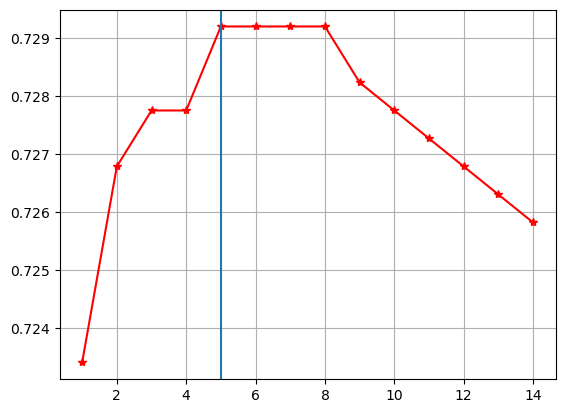

In [55]:
scores = []

for c in range(1,15,1):
    model = LogisticRegression(max_iter=1000,solver="sag",C=c)
    model.fit(X_train_vect,y_train_encode)
    y_pred = model.predict(X_test_vect)
    accuracy = accuracy_score(y_pred,y_test_encode)
    scores.append(accuracy)
plt.plot(list(range(1,15,1)),scores,'r-*')
plt.axvline(5)
plt.grid(True)
print("Best value of C : 5")

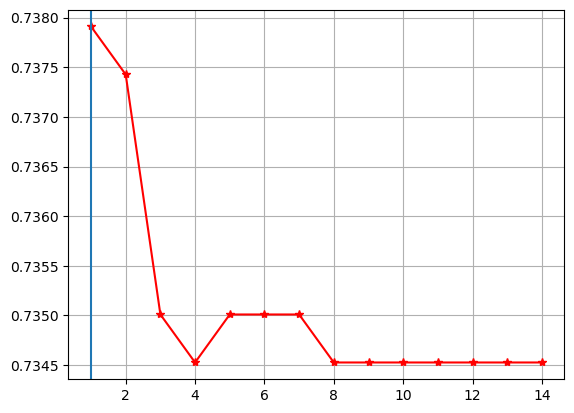

In [58]:
scores = []

for c in range(1,15,1):
    model = LinearSVC(max_iter=1000,C=c)
    model.fit(X_train_vect,y_train_encode)
    y_pred = model.predict(X_test_vect)
    accuracy = accuracy_score(y_pred,y_test_encode)
    scores.append(accuracy)
plt.plot(list(range(1,15,1)),scores,'r-*')
plt.axvline(1)
plt.grid(True)
print("Best value of C : 1")

## Test des modèles

In [33]:
language_detector("Le NLP est une branche de l'IA qui se concentre sur l'interaction entre les ordinateurs et le langage humain.",log_reg,vector,encoder)

This text is in French


In [34]:
language_detector("NLP is a branch of AI that focuses on the interaction between computers and human language.",log_reg,vector,encoder)

This text is in English


In [35]:
language_detector("L'NLP è una branca dell'IA che si concentra sull'interazione tra computer e linguaggio umano",log_reg,vector,encoder)

This text is in Italian


In [37]:
language_detector("NLP ist ein Zweig der KI, der sich auf die Interaktion zwischen Computern und menschlicher Sprache konzentriert",log_reg,vector,encoder)

This text is in German


In [39]:
language_detector("La PNL es una rama de la IA que se centra en la interacción entre los ordenadores y el lenguaje humano",log_reg,vector,encoder)

This text is in Spanish


### The end